<a href="https://colab.research.google.com/github/majapavi/UmjetnaInteligencija/blob/main/Klasifikacija_fotografija_prometnih_znakova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija fotografija prometnih znakova
izradila: Maja Pavičić<br>
kolegij: Umjetna inteligencija, prof. dr. sc. Luka Grubišić<br>
Prirodoslovno - matematički fakultet, Sveučilište u Zagrebu, veljača 2024.

 Cilj ovog projekta je istrenirati duboku konvolucijsku neuronsku mrežu, za klasificiranje fotografija prometnih znakova u 43 kategorije.

 Projekt je izrađen po uzoru na [vođeni projekt](https://www.coursera.org/projects/traffic-sign-classification-deep-learning) Ryana Ahmeda sa Coursere, koristi [German Traffic Sign Dataset](https://www.kaggle.com/datasets/harbhajansingh21/german-traffic-sign-dataset?select=test.p) preuzet sa Kagglea i Keras API za izradu mreže.

## Opis skupa podataka

[Podaci](https://www.kaggle.com/datasets/harbhajansingh21/german-traffic-sign-dataset?select=test.p)
 koje koristimo u ovom projektu preuzeti su sa Kagglea. Riječ je o fotografijama prometnih znakova sa njemačkih prometnica. Svaka fotografija prezentirana je kao 32x32 matrica sa 3 vrijednosti, što odgovara 32x32 piksela prikazana RGB tehnikom. Podaci su unaprijed podijeljeni na skupove za: treniranje modela (34799 primjera ili ~67% podataka), unakrsnu validaciju (4410 primjera ili ~8.5% podataka) i testiranje (12630 primjera ili ~24% poataka). Svaki od skupova podataka zapisan je u pickle formatu (ekstenzija .p). To je Python-specifičan format koji omogućava pretvorbu Python objekata u binarni format koji se može zapisati u datoteku i obrnuto. Svaki primjer (redak) u našim podacima sastoji se od dva stupca: u prvom je slika kako je ranije opisano, a u drugom je cjelobrojna oznaka klase. Klase su označene brojevima od 0 do 42, [ovdje](https://github.com/majapavi/Baza_podataka_za_klasifikaciju_prometnih_znakova/blob/main/signname.csv) možete vidjeti legendu koja povezuje oznaku klase i stvarno ime prometnog znaka.

## Učitavanje korištenih biblioteka i podataka

Najprije učitavamo sve potrebne biblioteke i funkcionalnosti.

In [ ]:
import matplotlib.pyplot as plt                             # za vizualizaciju podataka
import numpy as np                                          # za numeričku analizu podataka
import seaborn as sns                                       # za vizualizaciju podataka
import pickle                                               # ucitavanje (de-serijalizacija) podataka
import random
from tensorflow.keras import datasets, layers, models       # za izgradnju duboke neuronske mreže
from google.colab import drive                              # za povezivanje sa google-driveom
from sklearn.utils import shuffle                           # za mješanje poretka trening podataka
from sklearn.metrics import confusion_matrix                # za crtanje matrice KORELACIJE

Zatim učitavamo naše podatke. Fileovi s podacima su pohranjeni u javnom github repozitoriju kojeg kloniramo u naše Colab okruženje. Odgovarajuće fileove "unpickleamo" u varijable train, valid i test.

In [ ]:
!git clone https://github.com/majapavi/Baza_podataka_za_klasifikaciju_prometnih_znakova data_base

with open('/content/data_base/train.p', 'rb') as training_data:
    train = pickle.load(training_data)
with open('/content/data_base/valid.p', 'rb') as validation_data:
    valid = pickle.load(validation_data)
with open('/content/data_base/test.p', 'rb') as testing_data:
    test = pickle.load(testing_data)

Cloning into 'data_base'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 3), reused 13 (delta 1), pack-reused 0
Receiving objects: 100% (15/15), done.
Resolving deltas: 100% (3/3), done.
Filtering content: 100% (3/3), 152.22 MiB | 53.14 MiB/s, done.


Slijedi zapisivanje matrica piksela odnosno oznaka klasa u odgovarajuće X odnosno y varijable. Ispišemo dimenzije kreiranih varijabli, kako bismo provjerili da je sve dobro učitano i očekivanih dimenzija.

In [ ]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("X_train dimenzije:", X_train.shape)
print("y_train dimenzije:", y_train.shape)
print("X_validation dimenzije:", X_validation.shape)
print("y_validation dimenzije:", y_validation.shape)
print("X_test dimenzije:", X_test.shape)
print("y_test dimenzije:", y_test.shape)

X_train dimenzije: (34799, 32, 32, 3)
y_train dimenzije: (34799,)
X_validation dimenzije: (4410, 32, 32, 3)
y_validation dimenzije: (4410,)
X_test dimenzije: (12630, 32, 32, 3)
y_test dimenzije: (12630,)


## Vizualizacija podataka

Izaberimo sada nasumično stotinu od naših slika i prikažimo ih, kako bismo bolje vizualizirali podatke s kojima radimo.

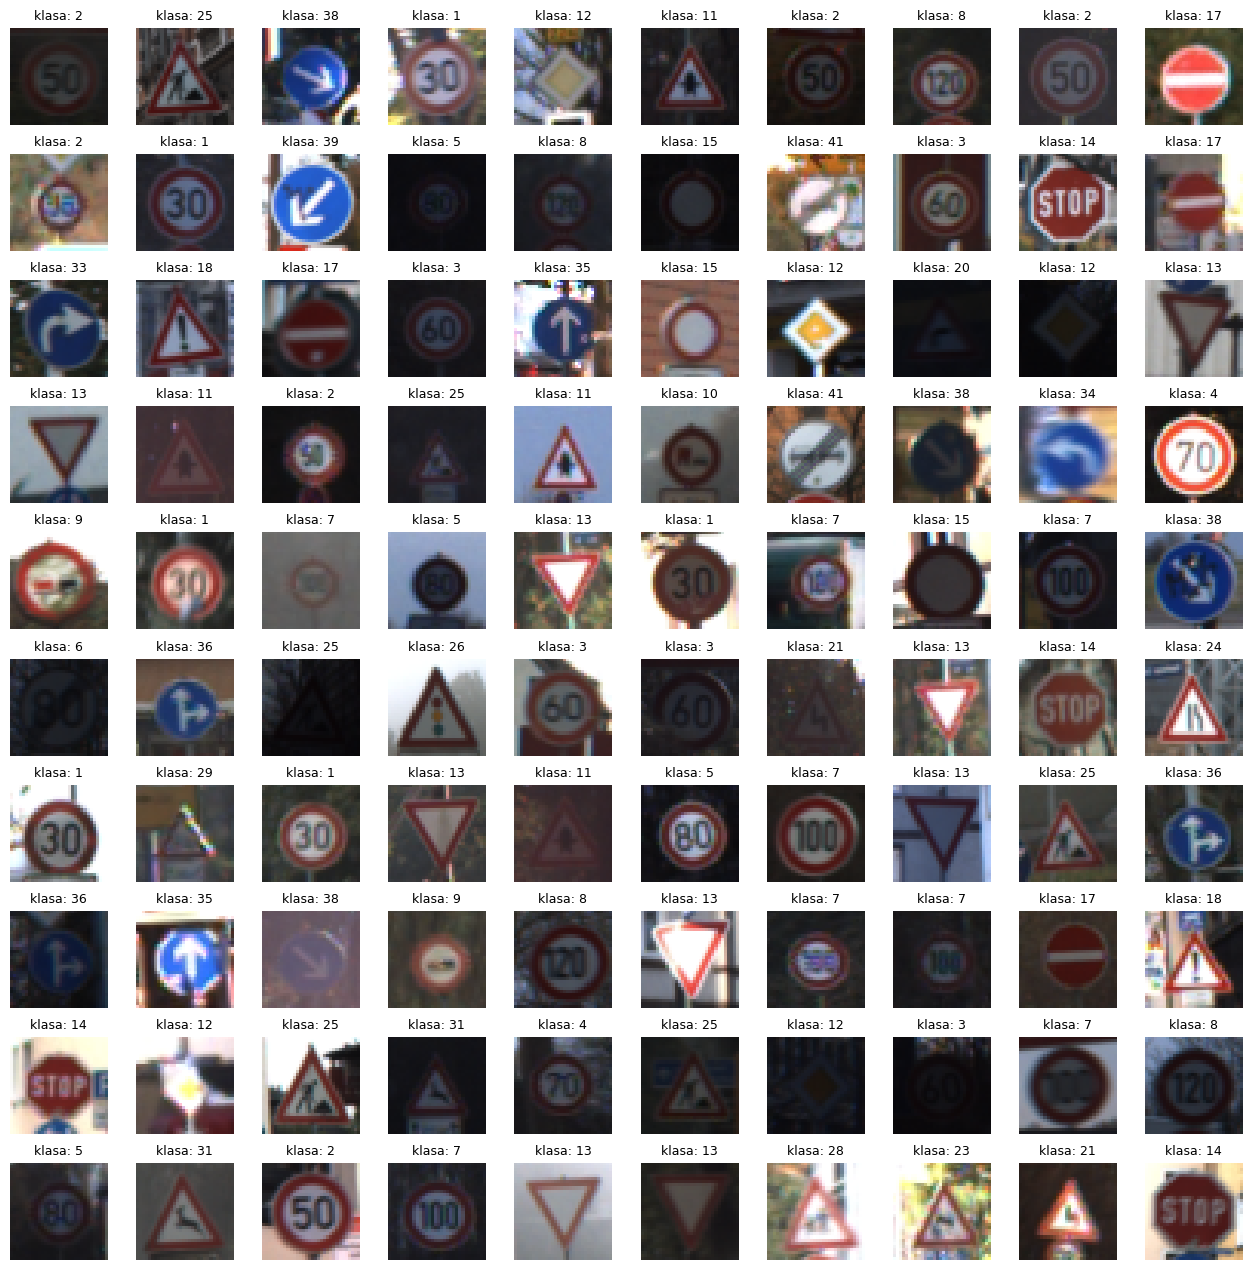

In [ ]:
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (16, 16))
axes = axes.ravel()

for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title('klasa: {}'.format(y_train[index]), fontsize = 9)
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.3)

## Pretvorba slika u crno-bijele i normalizacija

Naši podaci prolaze kroz sljedeći postupak obrade:

1.   **pomiješamo poredak podataka u setu za treniranje**, kako bismo osigurali da ne dolaze svi znakovi iste klase uzastopno - time osiguravamo da mreža ne uzima u obzir poredak slika prilikom određivanja klasa
2.   **pretvorimo slike iz obojanih u crno-bijele** tako da računamo srednju vrijednost RGB vrijednosti svakog piksela - tako dobivamo intenzitet (tj. svjetlinu) pojedinog piksela u crno-bijeloj skali, time smanjujemo broj parametara u modelu i uz istu količinu podataka za treniranje postižemo veću točnost mreže
3.  **normaliziramo vrijednosti piksela** - znamo da se intenzitet osvjetljenja pojedinog piksela kod crno-bijelih slika označava brojevima u rasponu [0, 256>, sada taj raspon transformiramo u raspon [-1, 1>, kako bi učenje bilo jednolikije za svijetlije i tamnije dijelove slike i kako bi se cijeli proces učenja ubrzao i učinio stabilnijim.

In [ ]:
X_train, y_train = shuffle(X_train, y_train)                            #(1)

X_train_gray = np.sum(X_train/3, axis = 3, keepdims = True)             #(2)
X_train_gray_norm = (X_train_gray - 128) / 128                          #(3)

X_validation_gray = np.sum(X_validation/3, axis = 3, keepdims = True)   #(2)
X_validation_gray_norm = (X_validation_gray - 128) / 128                #(3)

X_test_gray = np.sum(X_test/3, axis = 3, keepdims = True)               #(2)
X_test_gray_norm = (X_test_gray - 128) / 128                            #(3)

Sada možemo vizualizirati što dobijemo tim postupkom.
Slučajnim odabirom izdvojimo jednu sliku iz skupa za trening i prikažemo njezinu originalnu, crno-bijelu i normaliziranu crno-bijelu varijantu.

Indeks prikazane slike:  12875 



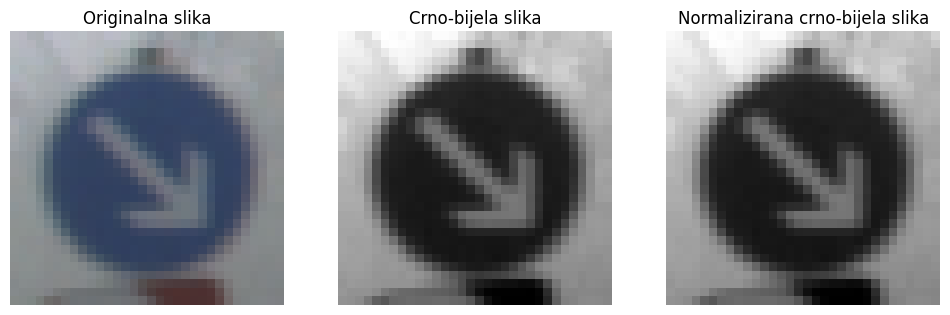

In [ ]:
i = random.randint(0, len(X_train_gray) - 1)
print("Indeks prikazane slike: ", i, "\n")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Originalna slika')
plt.imshow(X_train[i])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Crno-bijela slika')
plt.imshow(X_train_gray[i], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Normalizirana crno-bijela slika')
plt.imshow(X_train_gray_norm[i], cmap='gray')
plt.axis('off')

plt.show()

## Izgradnja mreže

Za izgradnju mreže koristimo Keras, API visoke razine za neuronske mreže, koji pruža jednostavan i intuitivan način izrade dubokih modela učenja. Može koristiti razne backendove, među njima i TensorFlow. Olakšava eksperimentiranje s arhitekturom neuronskih mreža i brzu izradu prototipova. Pogodan je širokom krugu korisnika jer omogućuje da se usredotoče na dizajn i konfiguraciju modela umjesto na detalje implementacije.

Mreža koju gradimo svoju strukturu bazira na LeNet-5 strukturi. LeNet je jedna od najranije razvijenih struktura konvolucijskih neuronskih mreža, prvotno je osmišljena kako bi mogla klasificirati slike rukom pisanih znamenki. Više o LeNet strukturi možete pročitati [ovdje](https://en.wikipedia.org/wiki/LeNet).

Evo detaljnog objašnjenja svakog dijela korištene mreže:

1. Conv2D slojevi: Prvi sloj Conv2D ima 6 filtera veličine (5, 5), što znači da će se primijeniti 6 različitih filtera na ulaznu sliku. Rezultat će imati dimenziju (28, 28, 6) jer se primjenjuje 6 filtera. Drugi Conv2D sloj ima 16 filtera iste veličine i rezultat će biti (10, 10, 16) dimenzija.

2. Aktivacijska funkcija 'relu': koristi se nakon svakog Conv2D sloja i dodaje nelinearnost u mrežu.

3. AveragePooling2D slojevi: Nakon svakog Conv2D sloja slijedi AveragePooling2D sloj koji smanjuje dimenzije izlazne slike. Ovo pomaže u smanjenju broja parametara i izbjegavanju prenaučenosti.

4. Dropout sloj: Sloj Dropout koristi se za regularizaciju mreže. On slučajno isključuje određeni postotak neurona tijekom treninga kako bi se spriječilo prenaučenost.


5. Flatten sloj: koristi se za pretvaranje izlaza konvolucijskih slojeva u (jednodimenzionalni) vektor, kako bi se mogao proslijediti potpuno povezanom sloju.

6. Dense slojevi: su potpuno povezani slojevi. Prvi ima 120 neurona, a drugi 84. Treći sloj ima 43 neurona (koliko i mogućih klasa) i koristi softmax aktivacijsku funkciju kako bi kao izlaz dobili vjerojatnosti pripadnosti slike pojedinoj klasi.

In [ ]:
CNN = models.Sequential()

CNN.add(layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (32, 32, 1)))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(16, (5, 5), activation = 'relu'))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu'))
CNN.add(layers.Dense(84, activation = 'relu'))
CNN.add(layers.Dense(43, activation = 'softmax'))

I od samog modela možemo tražiti kratki sažetak njegove strukture po slojevima.

In [ ]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0

## Kompilacija i treniranje mreže

Modelu smo kao parametre predali Adam optimizator i "sparse_categorical_crossentropy" funkciju gubitka, a za metriku uzimamo točnost, odnosno udio ispravno klasificiranih slika.

Za razliku od klasičnog, stohastičkog, gradijentnog spusta, koji ima jedinstvenu stopu učenja, Adam tijekom treninga prilagođava stopu učenja za svaku težinu posebno. Stope učenja određuje na temelju očekivanja i varijanci gradijenata. Više o Adam optimizaciji možete pročitati [ovdje](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/), a o optimizatorima dostupnim preko Kerasa [ovdje](https://keras.io/api/optimizers/).

Za funkciju gubitka koristili smo sparse_categorical_crossentropy koja računa gubitak po formuli sum(y_predviđeni - y_stvarni * log(y_prediđeni)). Ona je prikladna kada imamo višeklasni klasifikacijski problem, klase reprezentirane cijelim brojevima i primjere koji pripadaju točno jednoj klasi. Više o funkcijama gubitka dostupnim preko Kerasa pročitajte [ovdje](https://keras.io/api/losses/).

Prilikom treniranja mreži smo predali još nekoliko parametara - kroz prva dva podatke za treniranje, kroz zadnji podatke za unakrsnu validaciju. Parametrom batch_size određujemo koju količinu podataka provučemo kroz mrežu prije nego joj modificiramo parametre, a parametarom epochs koliko puta provučemo sve podatke kroz mrežu u procesu treniranja.

Ove parametre možemo varirati i vidjeti hoće li to utjecati na kvalitetu rezultata. Promatramo vrijednosti gubitka na skupu za treniranje i skupu za validaciju i želimo postići da vrijednosti funkcije gubitka budu minimalne, ali približno jednake na skupovima za validaciju i treniranje. Tada znamo da smo maksimalno utrenirali model, a da ga pritom nismo prenaučili ili previše prilagodili podacima za trening.

In [ ]:
CNN.compile(
    optimizer = 'Adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

history = CNN.fit(
            X_train_gray_norm,
            y_train,
            batch_size = 500,
            epochs = 10,
            validation_data = (X_validation_gray_norm, y_validation))

Epoch 1/10
70/70 [==============================] - 17s 220ms/step - loss: 3.2209 - accuracy: 0.1548 - val_loss: 2.8567 - val_accuracy: 0.2721
Epoch 2/10
70/70 [==============================] - 15s 215ms/step - loss: 2.0003 - accuracy: 0.4502 - val_loss: 1.6329 - val_accuracy: 0.5567
Epoch 3/10
70/70 [==============================] - 15s 216ms/step - loss: 1.2522 - accuracy: 0.6395 - val_loss: 1.1212 - val_accuracy: 0.6878
Epoch 4/10
70/70 [==============================] - 17s 237ms/step - loss: 0.8439 - accuracy: 0.7527 - val_loss: 0.8075 - val_accuracy: 0.7524
Epoch 5/10
70/70 [==============================] - 15s 214ms/step - loss: 0.6522 - accuracy: 0.8131 - val_loss: 0.6734 - val_accuracy: 0.7998
Epoch 6/10
70/70 [==============================] - 16s 233ms/step - loss: 0.5477 - accuracy: 0.8443 - val_loss: 0.6218 - val_accuracy: 0.8061
Epoch 7/10
70/70 [==============================] - 15s 214ms/step - loss: 0.4719 - accuracy: 0.8676 - val_loss: 0.5736 - val_accuracy: 0.8329

Sad ćemo još malo detaljnije prikazati podatke o gubitcima i točnosti koje smo pamtili u procesu treninga u varijabli history. Na grafovima ćemo iscrtati kako se u svakoj epohi treniranja mijenjala točnost i funkcija gubitka na testovima za validaciju i treniranje.

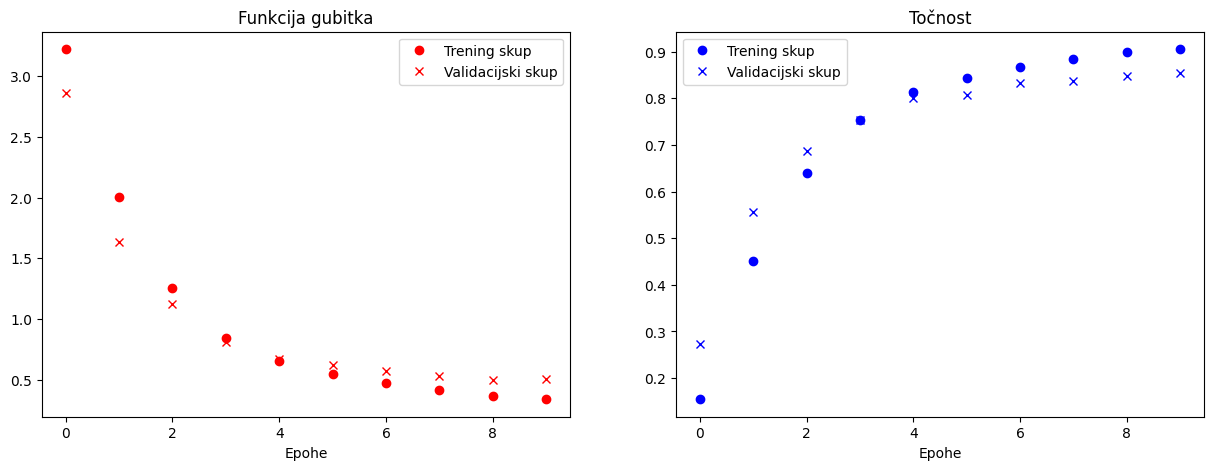

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Funkcija gubitka')
plt.plot(epochs, loss, 'ro', label='Trening skup')
plt.plot(epochs, val_loss, 'rx', label='Validacijski skup')
plt.xlabel('Epohe')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Točnost')
plt.plot(epochs, accuracy, 'bo', label='Trening skup')
plt.plot(epochs, val_accuracy, 'bx', label='Validacijski skup')
plt.xlabel('Epohe')
plt.legend()

plt.show()

Vidimo da u početku mreža bolje radi na validacijskom skupu, no oko pete epohe počinje bolje raditi na skupu za trening i ta razlika se polako povećava. To nam je znak da trebamo zaustaviti treniranje jer ćemo daljnjim treniranjem istim postupkom prenaučiti naš model.

## Procjena kvalitete izgrađenog modela

Isprobajmo sada napokon naš istrenirani model na testnom skupu kako bismo vidjeli koliku ćemo točnost dobiti.

In [ ]:
score = CNN.evaluate(X_test_gray_norm, y_test)
print('\nTočnost na testnom skupu je {}.'.format(score[1]))

395/395 [==============================] - 3s 7ms/step - loss: 0.7003 - accuracy: 0.8515

Točnost na testnom skupu je 0.8515439629554749.


Dobivena točnost je ~85%, čime smo zadovoljni.

Dobivena predviđanja za klase pohranjujemo u posebnu varijablu.

In [ ]:
predictions = CNN.predict(X_test_gray_norm)
predicted_classes = np.argmax(predictions, axis=1)

395/395 [==============================] - 5s 13ms/step


array([[4.5146629e-18, 5.1977835e-14, 4.6376202e-14, ..., 2.3512514e-05,
        9.1777110e-08, 1.8297371e-07],
       [2.8181639e-03, 9.9000055e-01, 5.6306734e-03, ..., 1.3441147e-09,
        3.6597191e-11, 5.9631562e-09],
       [7.3421827e-21, 1.6776973e-18, 2.0833953e-16, ..., 1.4036122e-14,
        1.0816439e-11, 5.8044039e-20],
       ...,
       [5.4264406e-04, 5.5510644e-02, 2.0987448e-01, ..., 1.7164843e-05,
        1.1720391e-03, 2.4288234e-05],
       [5.8296259e-06, 7.7359001e-03, 1.7504252e-02, ..., 5.0966069e-03,
        1.3954710e-04, 1.3378839e-03],
       [1.5784715e-06, 3.6388627e-04, 6.3061262e-03, ..., 1.2675292e-03,
        7.8477935e-09, 1.1493638e-08]], dtype=float32)

Iscrtajmo sada još i matricu zabune. Pojedini retci matrice reprezentiraju stvarne klase, a pojedini stupci klase koje je predvidio naš model. U svakom polju matrice nalazi se broj slika testnog skupa koje pripadaju pripadnom retku i stupcu. Broj slika u pojedinom polju dodatno je naglašen bojama. Vidimo da izvan dijagonale imamo mnogo nula te da su sva polja izvan dijagonale svijetlo žuta, što je još jedan pokazatelj dobrog predviđanja.

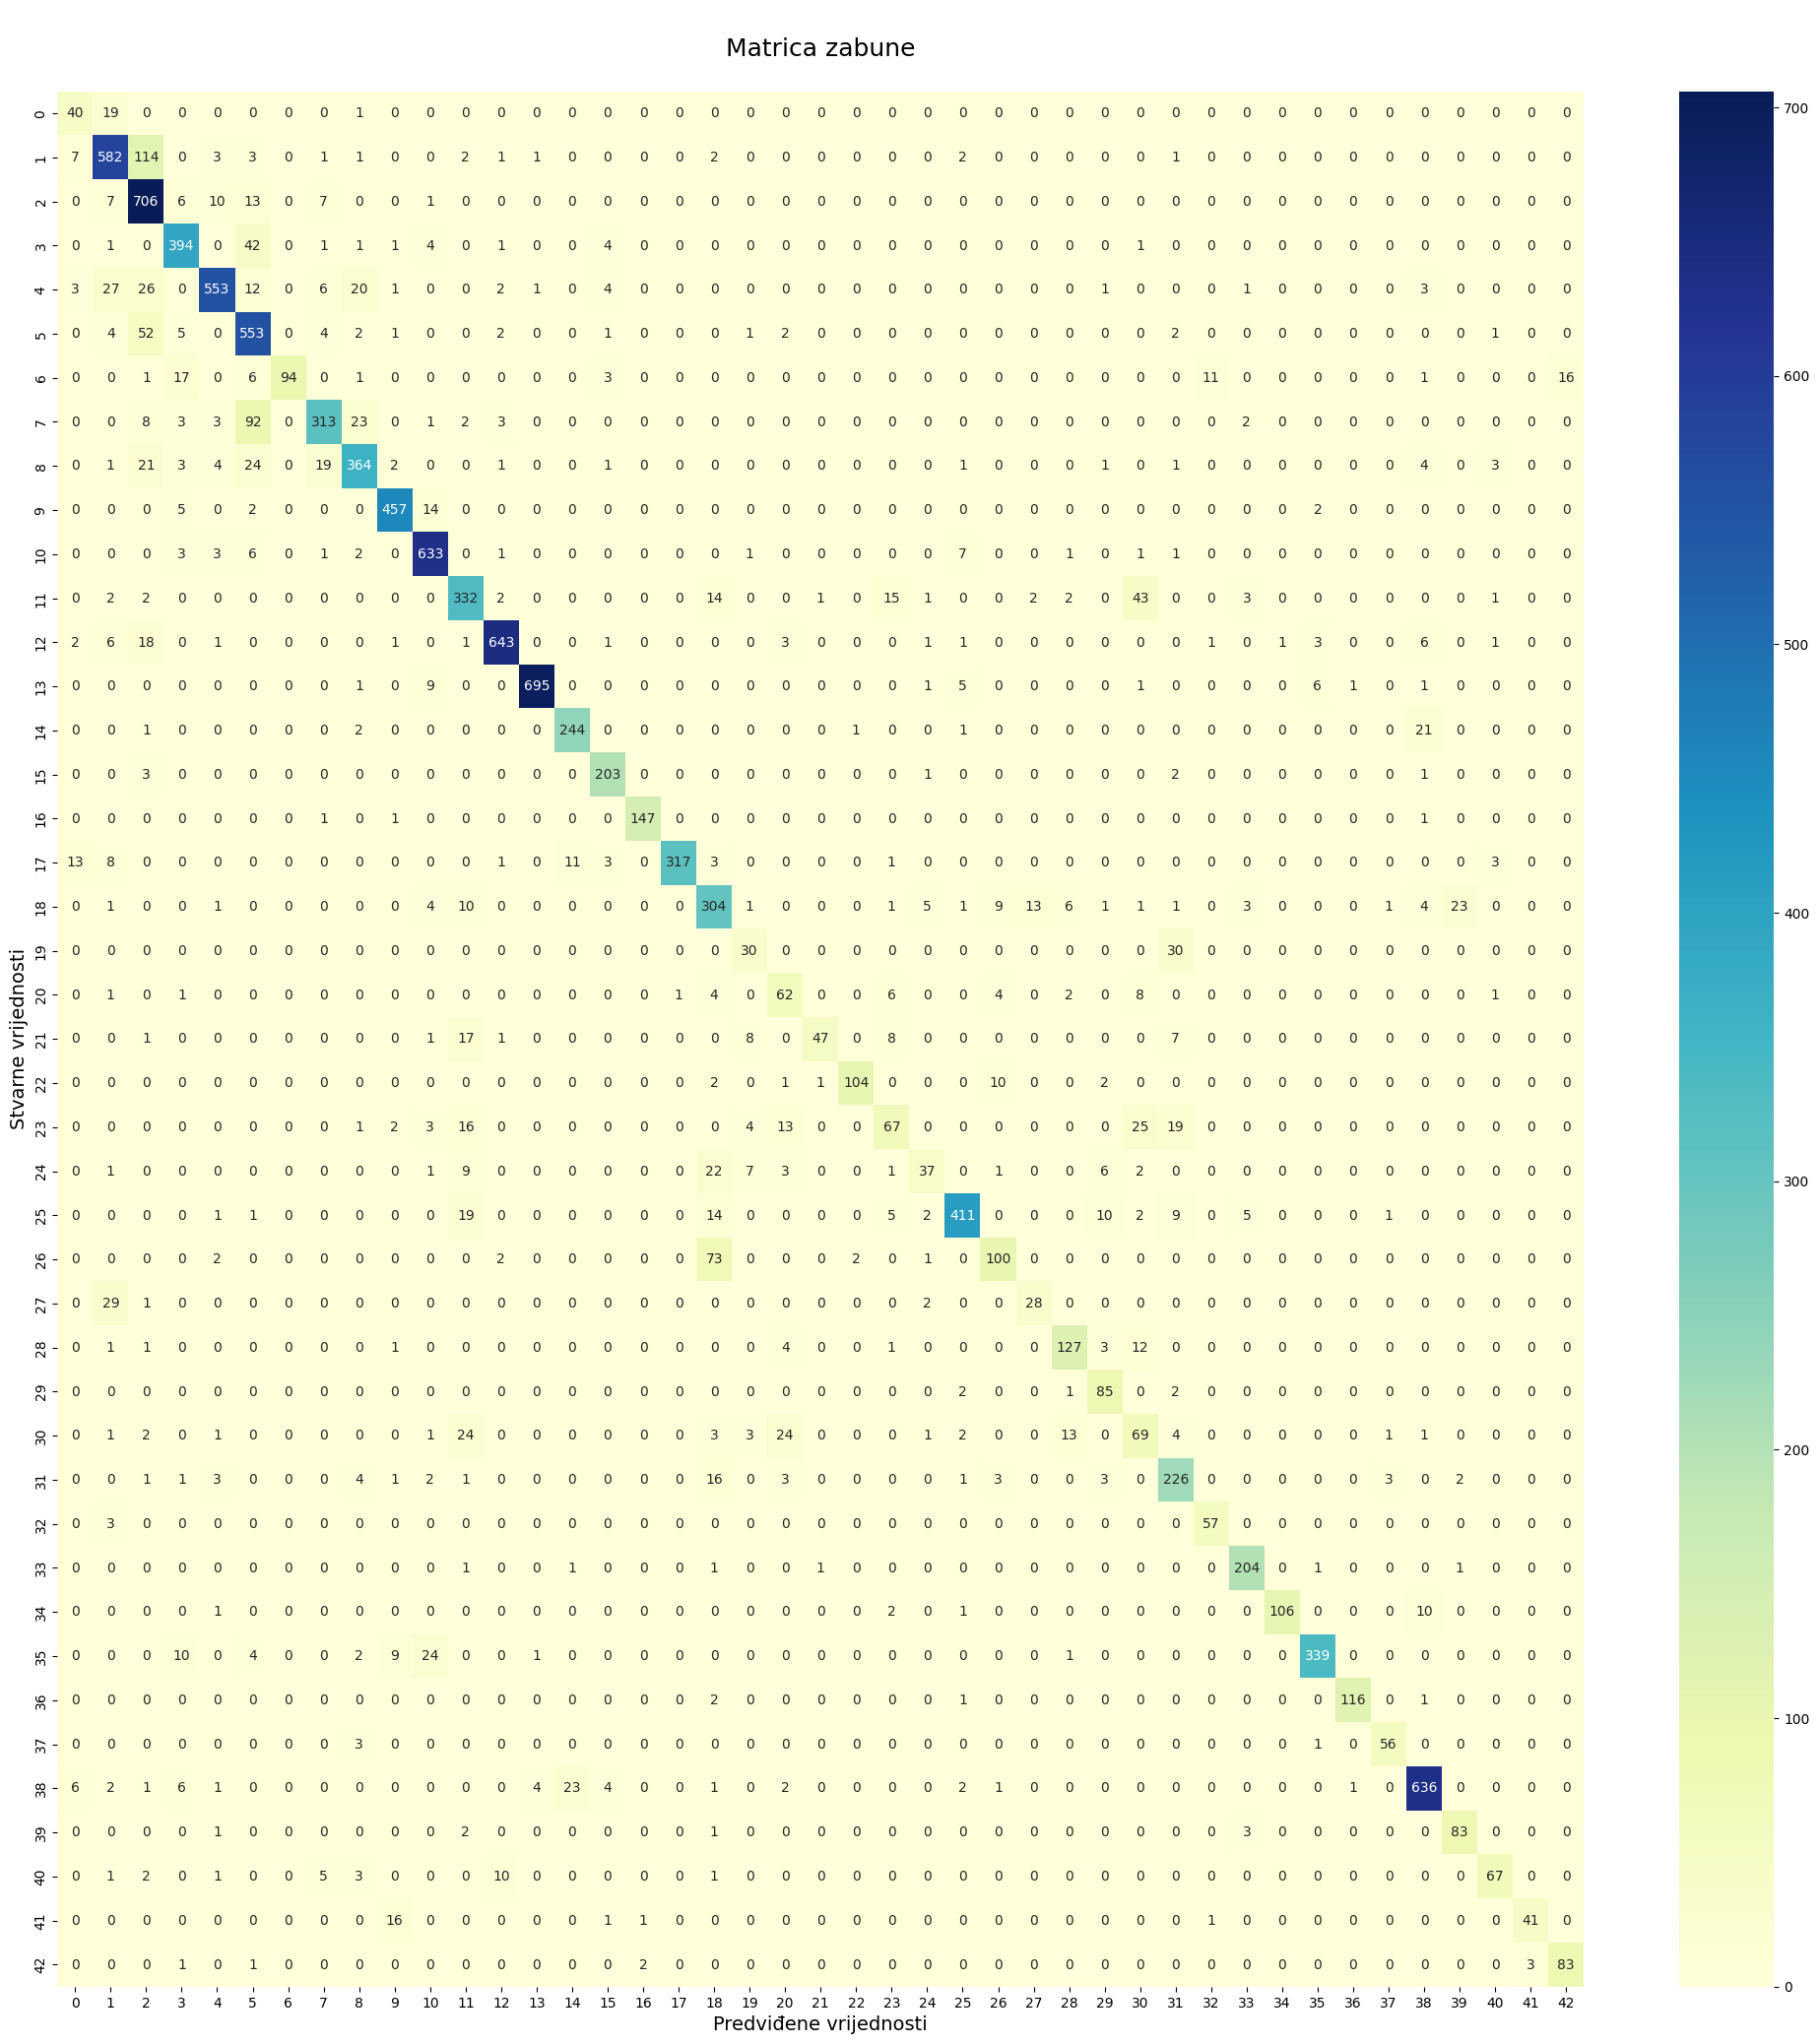

In [ ]:
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True, fmt='d', cmap='YlGnBu')

plt.title('\nMatrica zabune\n', fontsize = 18)
plt.xlabel('Predviđene vrijednosti', fontsize = 14)
plt.ylabel('Stvarne vrijednosti', fontsize = 14)
plt.show()

U svrhu procjene kvalitete modela, možemo i prikazati neke od fotografija koje su pogrešno klasificirane, kako bismo procjenili koliko su znakovi na njima prepoznatljivi iz ljudske perspektive.

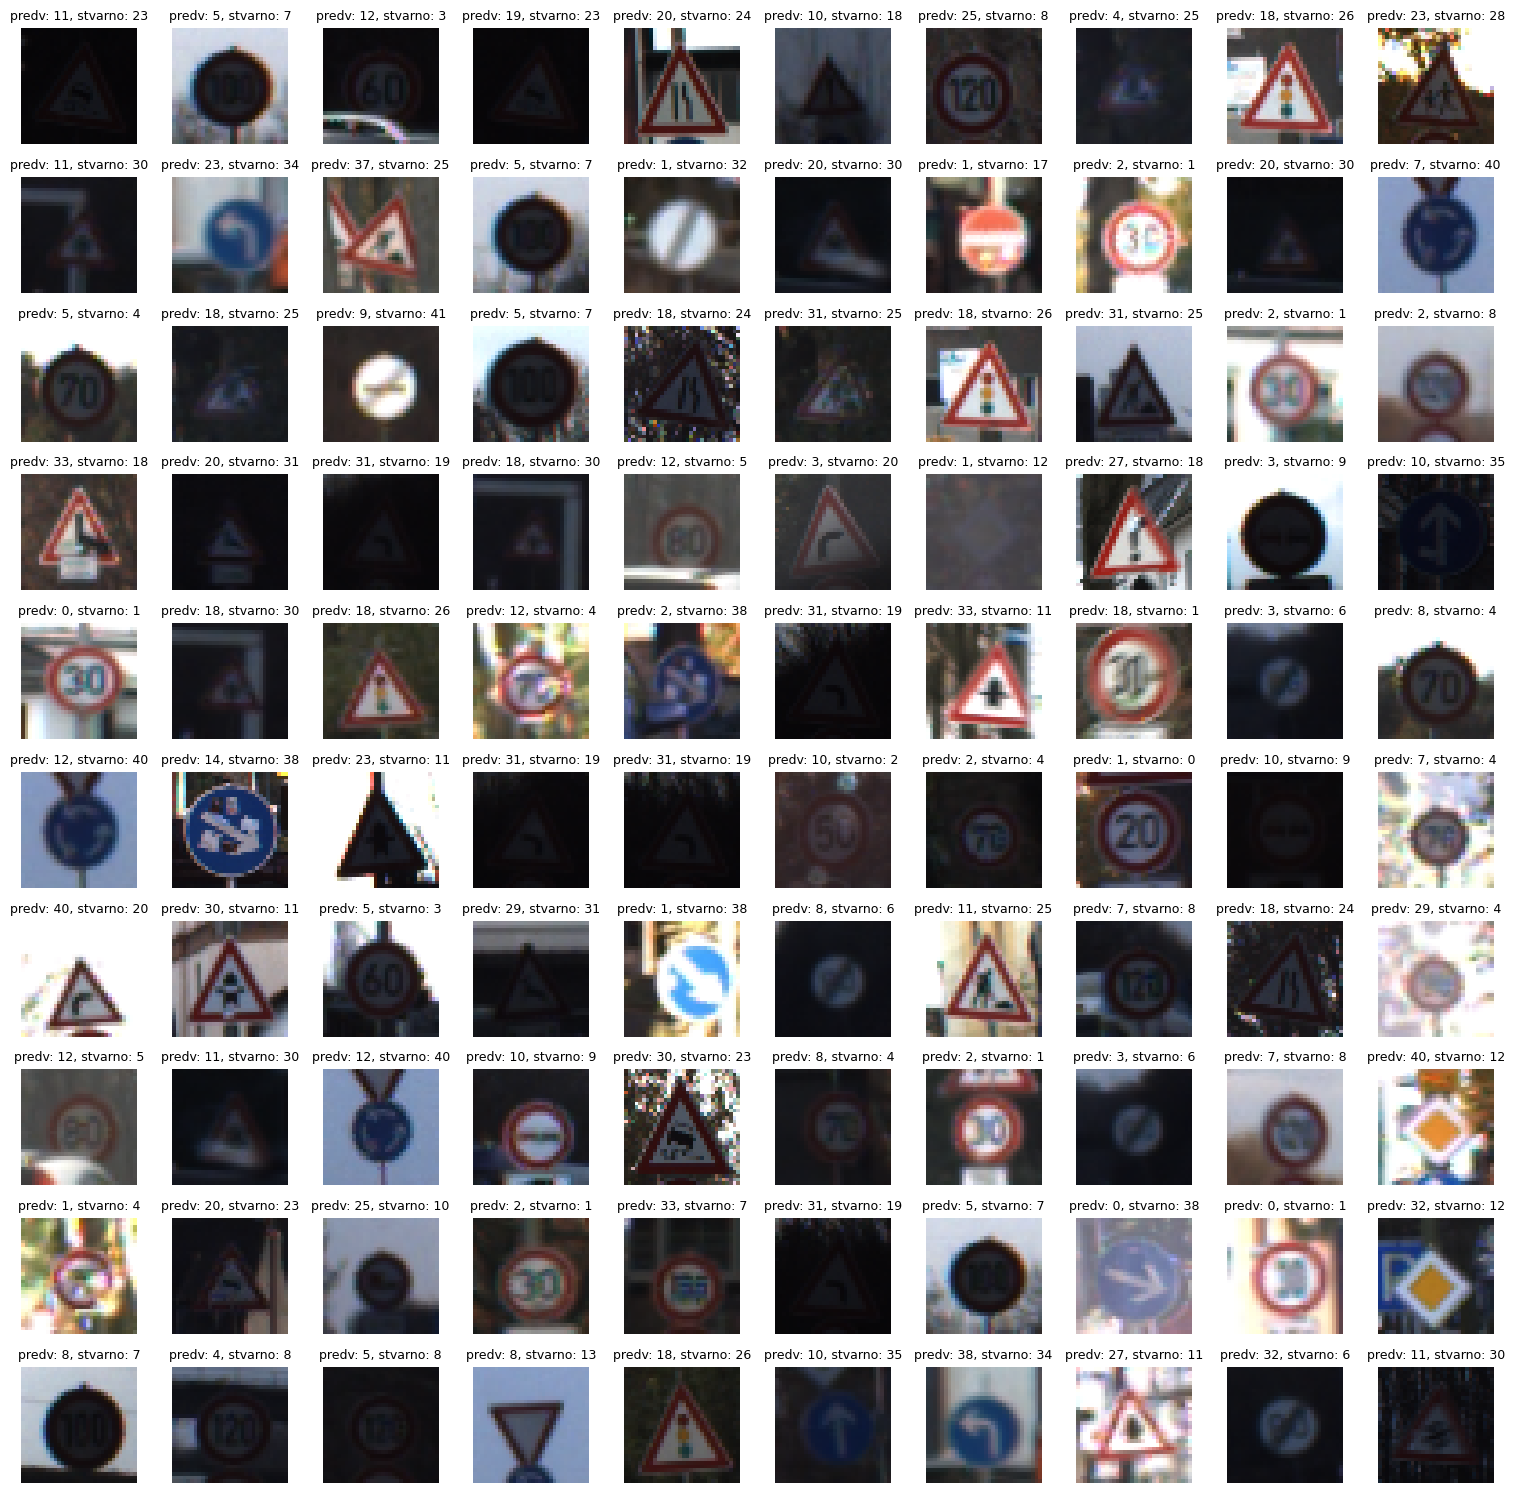

In [ ]:
L = 10
W = 10

incorrect_indexes = np.where(predicted_classes != y_test)[0]

fig, axes = plt.subplots(L, W, figsize=(19, 19))
axes = axes.ravel()

for i in range(L*W):
    axes[i].imshow(X_test[incorrect_indexes[i]])
    axes[i].set_title('predv: {}, stvarno: {}'.format(predicted_classes[incorrect_indexes[i]], y_test[incorrect_indexes[i]]), fontsize = 9)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.3)
plt.show()

 Vidimo da među pogrešno klasificiranim fotografijama ima veliki udio onih koje niti čovjek vjerojatno ne bi mogao ispravno prepoznati (jer su pretamne, premutne ili u preniskoj rezoluciji), pa takve pogreške niti ne pripisujemo našem modelu. Među misklasificiranim slikama ima i onih koje ljudima ne bi predstavljale problem za raspoznavanje, ali uzimajući u obzir točnost od ~85% možemo zaključiti da smo zadovoljni sa mrežom koju smo izgradili.

## Izvori i poveznice

* [Vođeni projekt "Traffic Sign Classification Using Deep Learning in Python/Keras", Ryan Ahmed, Coursera](https://www.coursera.org/projects/traffic-sign-classification-deep-learning)
* [German Traffic Sign Dataset, Sebastian Houben i Johannes Stallkamp, Kaggle](https://www.kaggle.com/datasets/harbhajansingh21/german-traffic-sign-dataset?select=test.p)
* [Repozitorij s pohranjem podacima korištenim u projektu, Maja Pavičić](https://github.com/majapavi/Baza_podataka_za_klasifikaciju_prometnih_znakova/)
* [Članak o LeNet strukturi, Wikipedia](https://en.wikipedia.org/wiki/LeNet)
* [Keras API dokumentacija](https://keras.io/api/)
* [Tečaj Supervised Machine Learning: Regression and Classification, Andrew Ng, Coursera](https://www.coursera.org/learn/machine-learning)